## Racist Tweets Analysis

This is a supervised machine learning project using logistic regression model to identify racist tweets

### Imports

In [1]:
# library  for using regular expressions 
import re
# used for reading, modifying, sorting, or deleting in the dataset
import pandas as pd
# used for numbers and matrices
import numpy as np
# plotting library
import matplotlib.pyplot as plt
# used for plotting seaborn plots and visualising data
import seaborn as sns
# used for a number of constants and classes
import string
# natural language processing
import nltk
# used to ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore",category = DeprecationWarning)
# used to  show the plots in the notebook instead of a separate window
%matplotlib inline

### Reading the Datasets

In [2]:
# reading the datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
#  shows the top rows in the dataset
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


The train and test datasets are combined ignoring their labels (they don't have the same index)

In [5]:
combination = train.append(test,ignore_index=True)

In [6]:
combination.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


Create a funtion that finds the occurances of a certain pattern in a string and stores them in a list then for each word in the list the word removed or subbed with an empty string

In [7]:
def delete_pattern(string, pattern):
    changes = re.findall(pattern,string)
    for word in changes:
        string = re.sub(word,"",string)
    return string

This line is used to remove twitter handles. A new attribute named "cleaned tweet" is created and contains the tweet after preprocessing. 
np.vectorize takes a function and applies it to each row in the specified column here it takes a regular expression consisting of @ followed by any word

In [8]:
combination["cleaned tweet"] = np.vectorize(delete_pattern)(combination["tweet"], "@[\w]*")

The cleaned tweet is converted to string then any special characters, numbers, and punctuation with a whitespace are replaced.
regex is set to true for replace to word with a regular expression

In [9]:
combination["cleaned tweet"] = combination["cleaned tweet"].str.replace("[^a-zA-Z#]"," ",regex = True)

A lambda function is applied on all rows in cleaned tweet. This function combines the strings leaving spaces between them.
.split is used to give a list of words if the length of the word is greater than 4. This removes the short words of less than 3 characters as they will not affect analysis.

In [10]:

combination["cleaned tweet"] = combination["cleaned tweet"].apply(lambda tweet: " ".join([word for word in tweet.split() if len(word) >=4]))

In [11]:
combination.head()

,id,label,tweet,cleaned tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


A lambda function is applied on the cleaned tweet column. It takes the string and splits it giving a list of words.

In [12]:
tokenized = combination["cleaned tweet"].apply(lambda string: string.split()) 

In [13]:
tokenized.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: cleaned tweet, dtype: object

In [14]:
"""
nltk library is used to stem each word
stemming is the  process used to strip the suffixes from a word
"""
stemmer = nltk.PorterStemmer()
tokenized = tokenized.apply(lambda string: [stemmer.stem(word) for word in string])

In [15]:
tokenized.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: cleaned tweet, dtype: object

The tokens together are stitched back together to go back to a sentence

In [16]:
for i in range(0,len(tokenized)):
    tokenized[i] = " ".join(tokenized[i])
combination["cleaned tweet"] = tokenized

In [17]:
combination.head()

,id,label,tweet,cleaned tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit caus they offer wheelchair ...
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


This function finds all the hashtags that are followed by a word they are then appended to list and returned

In [18]:
def findhashtags(string):
    hashtags = []
    for word in string:
        hashtag = re.findall(r"#(\w+)", word)
        hashtags.append(hashtag)
    return hashtags

Two lists are created for racist and non-racist hashtags. The dataset is  already labelled with zero and one where zero is non-racist and one is racist. The string passed to the findhashtags takes the condition where the label == 0 for non racist and == 1 for racist. Since combination has test data which is unlabelled, if the field isn't found it is ignored (only training data is used for this part).

In [19]:
non_racist_hashtags = findhashtags(combination["cleaned tweet"][combination["label"] == 0])
racist_hashtags = findhashtags(combination["cleaned tweet"][combination["label"] == 1])

#these functions remove the empty sets
non_racist_hashtags = sum(non_racist_hashtags,[])
racist_hashtags = sum(racist_hashtags,[])

### Data Visualization

Frequency distribution plots are created for the racist and non racist hashtags.

#### Racist Hashtags Graph

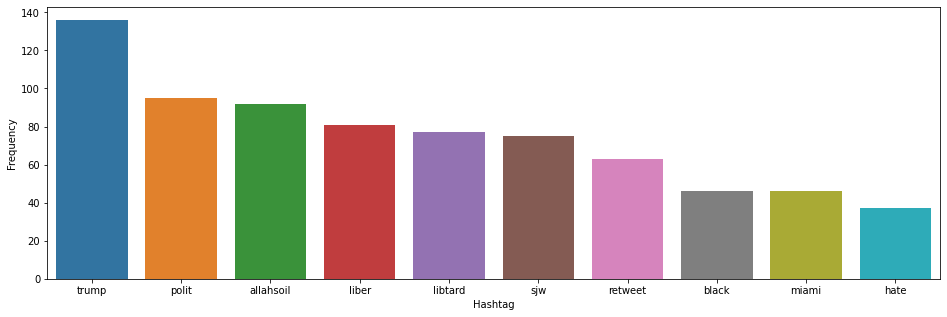

In [20]:
"""
this section creates a frequency distribution for the hashtags in order to visualize them
"""
a = nltk.FreqDist(racist_hashtags)
d = pd.DataFrame(
    {
      'Hashtag': list(a.keys()), #hashtags contains the hashtag names
     'Frequency': list(a.values())} # frequency has the values or the frequency
    )
d = d.nlargest(columns="Frequency", n=10) #gets the highest 10 frequencies 
plt.figure(figsize=(16,5)) #plots the graph with specific dimensions
ax = sns.barplot(data=d, x= "Hashtag", y="Frequency") # graph data, axis data
ax.set(ylabel = 'Frequency') # sets the label to "frequency"
plt.show() #prints the graph

#### Non-racist Hashtags Graph

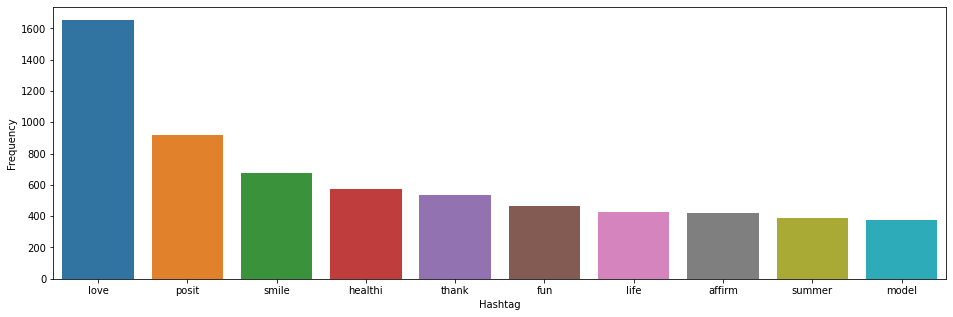

In [21]:
"""
the graph methods are applied for the non  racist hashtags
"""
a = nltk.FreqDist(non_racist_hashtags)
d = pd.DataFrame(
    {
      'Hashtag': list(a.keys()),
     'Frequency': list(a.values())}
    )
d = d.nlargest(columns="Frequency", n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y="Frequency")
ax.set(ylabel = 'Frequency')
plt.show()

### Machine Learning Model Training

In [22]:
"""
since machine learning cannot effiecient process the language as it is
it is  more efficient to turn those words into numbers
bag of words approch is adopted in this case: it involves gathering all the words in the dataset and 
representing each tweet using this an array to indicate the occurance of each word index in  the bag of words
essentially, the tweet becomes a list of frequencies of each word occurance. For example if a word of index 1 
in the bag of words does not occur in the tweet then 0 will be used at index 1 in the list representing that word
"""
# sklearn is responsible for machine learning
from sklearn.feature_extraction.text import CountVectorizer
# count vectorizer sets the highest count for words to 1000
bowVectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words="english")
"""
takes a dataset and transforms it to have the same format or coordinates as cleaned tweet combination, 
essentially maps it to it so for each tweet there is a bag of words  for  it
"""
bow = bowVectorizer.fit_transform(combination['cleaned tweet'])

In [23]:
"""
logistic regression is a type of supervised learning used when model classification is needed
train is solved 
test is the one that identifies whether training was done right or wrong
"""
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score # measures the correctness of the model

# create bag of words for train and test
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtraining_data, xtesting_data, ytraining_data, ytesting_data = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3) #30 percent is for testing

lreg = LogisticRegression() #initialize the model
lreg.fit(xtraining_data, ytraining_data) # training the model

prediction = lreg.predict_proba(xtesting_data) # predicting on the validation set, begin solving on testing set
prediction_int = prediction[:,1] >= 0.2 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)
f1_score(ytesting_data, prediction_int) # calculating f1 score


0.5407725321888412

In [24]:
"""
applying this to the test dataset
"""
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['tweet','label']]
submission.to_csv('racism_twitter_analysis_model_results.csv', index=False) # writing data to a CSV file